# Experiment 1 Object Oriented
Considering the nature of nodes, the next step is to improve the experimental protocol by using an object-oriented approach and experimenting with nodes as a class to explore the reasons why the results in the previous step were counter-intuitive.


In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, expon

Defining Nodes
Fixed alpha value = 1

In [121]:
class Node:
    def __init__(self, mean_load, stddev_load, rate_latency, T):
        self.mean_load = mean_load
        self.stddev_load = stddev_load
        self.rate_latency = rate_latency
        self.T = T
        self.load_data = np.random.normal(mean_load, stddev_load, T)
        self.latency_data = np.random.exponential(1 / rate_latency, T)

    def get_load_reward(self, t):
        load = self.load_data[t]
        return 1 / (1 + load)

    def get_latency_reward(self, t):
        latency = self.latency_data[t]
        alpha = 1  # Fixed alpha value = 1
        return np.exp(-alpha * latency)

    def expected_load_reward(self): # Used to calculate the best rewards
        return 1 / (1 + self.mean_load)

    def expected_latency_reward(self): # Used to calculate the best rewards
        return np.exp(-1 / self.rate_latency)

Defining Epsilon Greedy MAB Class

In [122]:
class EpsilonGreedyMAB:
    def __init__(self, nodes, epsilon):
        self.nodes = nodes
        self.epsilon = epsilon
        self.counts = np.zeros(len(nodes))
        self.cumulative_rewards = np.zeros(len(nodes))
        self.cumulative_regret = 0

    def select_node(self, t, reward_type, best_reward):
        if np.random.rand() < self.epsilon:
            node_index = np.random.choice(len(self.nodes))
        else:
            node_index = np.argmax(self.cumulative_rewards / (self.counts + 1e-10))

        if reward_type == "load":
            reward = self.nodes[node_index].get_load_reward(t)
        elif reward_type == "latency":
            reward = self.nodes[node_index].get_latency_reward(t)

        self.counts[node_index] += 1
        self.cumulative_rewards[node_index] += reward

        regret = best_reward - reward
        self.cumulative_regret += regret

        return node_index, reward, regret

In [123]:
class Experiment:
    def __init__(self, node_configs, epsilon_values, T):
        self.node_configs = node_configs
        self.epsilon_values = epsilon_values
        self.T = T
        self.results = []

    def run(self):
        for epsilon in self.epsilon_values:
            nodes = [Node(config['mean_load'], config['stddev_load'], config['rate_latency'], self.T) for config in self.node_configs]
            mab = EpsilonGreedyMAB(nodes, epsilon)

            selected_nodes_load = []
            selected_nodes_latency = []
            cumulative_regrets_load = np.zeros(self.T)
            cumulative_regrets_latency = np.zeros(self.T)

            best_reward_load = max([node.expected_load_reward() for node in nodes])
            best_reward_latency = max([node.expected_latency_reward() for node in nodes])

            for t in range(self.T):
                node_index_load, reward_load, regret_load = mab.select_node(t, "load", best_reward_load)
                node_index_latency, reward_latency, regret_latency = mab.select_node(t, "latency", best_reward_latency)

                selected_nodes_load.append(node_index_load)
                selected_nodes_latency.append(node_index_latency)
                cumulative_regrets_load[t] = mab.cumulative_regret
                cumulative_regrets_latency[t] = mab.cumulative_regret

            best_nodes_load = np.argsort([np.mean(node.load_data) for node in nodes])[:10]
            best_nodes_latency = np.argsort([np.mean(node.latency_data) for node in nodes])[:10]

            top1_accuracy_load = self.top_k_accuracy(selected_nodes_load, best_nodes_load, 1)
            top5_accuracy_load = self.top_k_accuracy(selected_nodes_load, best_nodes_load, 5)
            top10_accuracy_load = self.top_k_accuracy(selected_nodes_load, best_nodes_load, 10)

            top1_accuracy_latency = self.top_k_accuracy(selected_nodes_latency, best_nodes_latency, 1)
            top5_accuracy_latency = self.top_k_accuracy(selected_nodes_latency, best_nodes_latency, 5)
            top10_accuracy_latency = self.top_k_accuracy(selected_nodes_latency, best_nodes_latency, 10)

            self.results.append((epsilon, {
                "top1_load": top1_accuracy_load,
                "top5_load": top5_accuracy_load,
                "top10_load": top10_accuracy_load,
                "top1_latency": top1_accuracy_latency,
                "top5_latency": top5_accuracy_latency,
                "top10_latency": top10_accuracy_latency,
                "cumulative_regrets_load": cumulative_regrets_load,
                "cumulative_regrets_latency": cumulative_regrets_latency
            }))

    def top_k_accuracy(self, selected_nodes, best_nodes, k):
        top_k_selected = np.argsort(selected_nodes)[-k:]
        return len(set(top_k_selected).intersection(set(best_nodes))) / k

    def plot_results(self, title):
        fig, ax = plt.subplots(2, 2, figsize=(14, 12))

        # Plot cumulative regrets as line charts for load
        for epsilon, result in self.results:
            cumulative_regrets_load = result['cumulative_regrets_load']
            ax[0, 0].plot(range(self.T), cumulative_regrets_load, label=f'Epsilon: {epsilon}')
        ax[0, 0].set_title("Cumulative Regret Over Time (Load)")
        ax[0, 0].set_xlabel("Iterations")
        ax[0, 0].set_ylabel("Cumulative Regret")
        ax[0, 0].legend()

        # Plot top-k accuracy as bar charts for load
        top1_load = [res[1]['top1_load'] for res in self.results]
        top5_load = [res[1]['top5_load'] for res in self.results]
        top10_load = [res[1]['top10_load'] for res in self.results]

        x = np.arange(len(self.epsilon_values))
        width = 0.2

        ax[1, 0].bar(x - width, top1_load, width, label='Top-1')
        ax[1, 0].bar(x, top5_load, width, label='Top-5')
        ax[1, 0].bar(x + width, top10_load, width, label='Top-10')

        ax[1, 0].set_title("Top-K Accuracy (Load)")
        ax[1, 0].set_xlabel("Epsilon")
        ax[1, 0].set_ylabel("Accuracy")
        ax[1, 0].set_xticks(x)
        ax[1, 0].set_xticklabels([str(e) for e in self.epsilon_values])
        ax[1, 0].legend()

        # Plot cumulative regrets as line charts for latency
        for epsilon, result in self.results:
            cumulative_regrets_latency = result['cumulative_regrets_latency']
            ax[0, 1].plot(range(self.T), cumulative_regrets_latency, label=f'Epsilon: {epsilon}')
        ax[0, 1].set_title("Cumulative Regret Over Time (Latency)")
        ax[0, 1].set_xlabel("Iterations")
        ax[0, 1].set_ylabel("Cumulative Regret")
        ax[0, 1].legend()

        # Plot top-k accuracy as bar charts for latency
        top1_latency = [res[1]['top1_latency'] for res in self.results]
        top5_latency = [res[1]['top5_latency'] for res in self.results]
        top10_latency = [res[1]['top10_latency'] for res in self.results]

        ax[1, 1].bar(x - width, top1_latency, width, label='Top-1')
        ax[1, 1].bar(x, top5_latency, width, label='Top-5')
        ax[1, 1].bar(x + width, top10_latency, width, label='Top-10')

        ax[1, 1].set_title("Top-K Accuracy (Latency)")
        ax[1, 1].set_xlabel("Epsilon")
        ax[1, 1].set_ylabel("Accuracy")
        ax[1, 1].set_xticks(x)
        ax[1, 1].set_xticklabels([str(e) for e in self.epsilon_values])
        ax[1, 1].legend()

        fig.suptitle(title)
        plt.show()

Experiment 1 (Close means and rates):
Epsilon: 0.01, Results: {'top1_load': 0.0, 'top5_load': 0.0, 'top10_load': 0.0, 'top1_latency': 0.0, 'top5_latency': 0.0, 'top10_latency': 0.0, 'cumulative_regrets_load': array([ -0.22625821,  -0.48295906,  -0.59011297,  -0.69051951,
        -0.69276277,  -0.74671363,  -0.96755915,  -1.15601472,
        -1.26507455,  -1.43084077,  -1.49983634,  -1.72408786,
        -1.54094748,  -1.72957608,  -1.9367979 ,  -1.97089016,
        -2.21696497,  -2.10608198,  -2.21537155,  -2.24149623,
        -2.22065583,  -1.7871428 ,  -1.71255387,  -1.75300368,
        -1.83119901,  -1.84892891,  -2.07255732,  -2.01572792,
        -2.19046958,  -2.47174476,  -2.65181064,  -2.82199482,
        -3.06325118,  -3.19266003,  -3.21392812,  -3.02811961,
        -2.71703176,  -2.96730339,  -2.60234442,  -2.45159656,
        -2.49614744,  -2.65587703,  -2.81632375,  -3.0002034 ,
        -3.16603343,  -3.12558762,  -2.86767121,  -2.3059761 ,
        -2.40378174,  -1.94532533, 

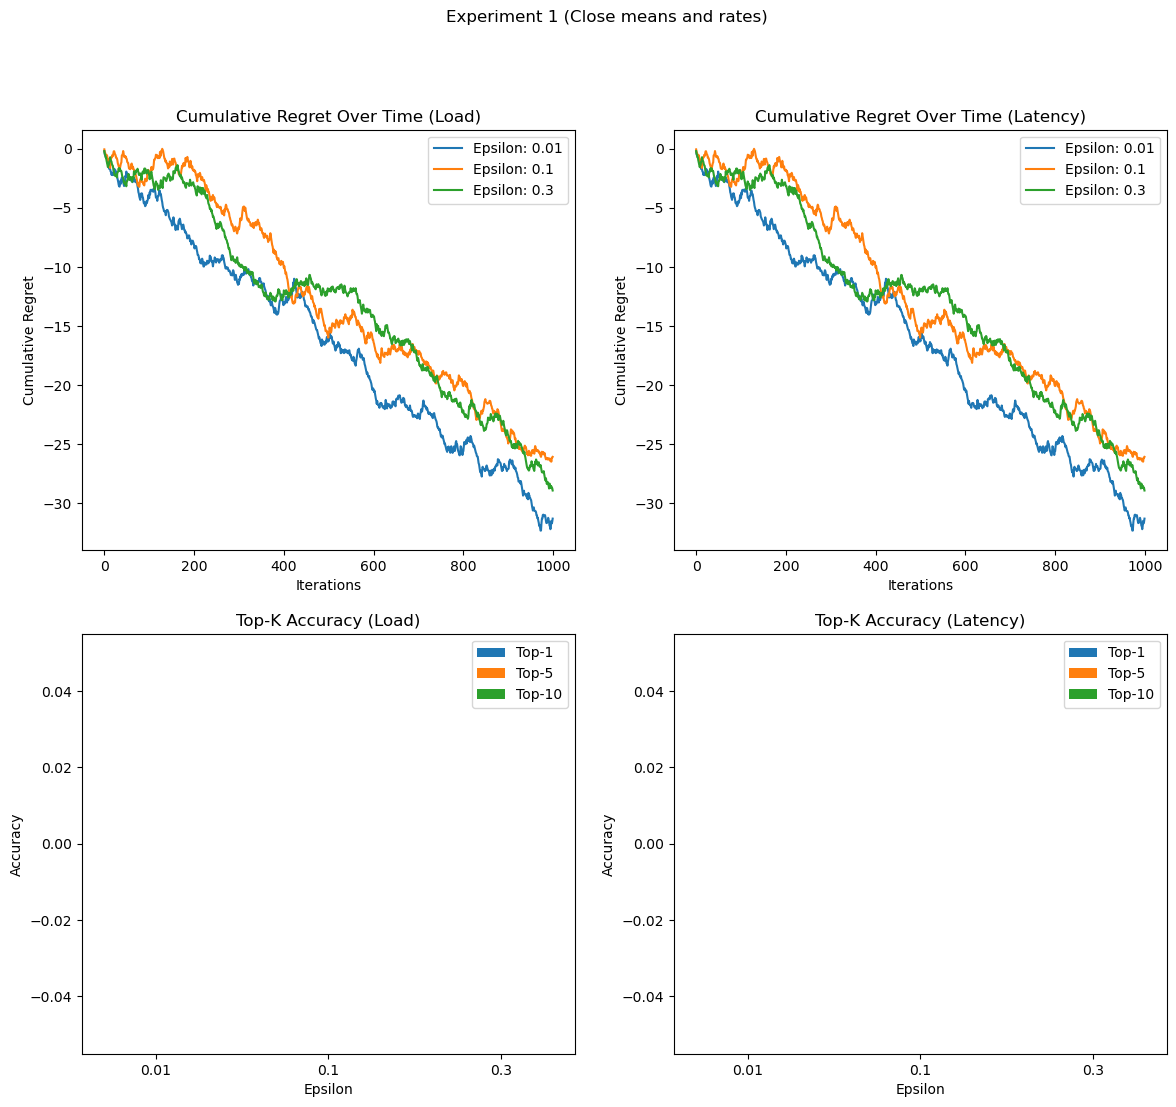


Experiment 2 (Diverse means and rates):
Epsilon: 0.01, Results: {'top1_load': 0.0, 'top5_load': 0.0, 'top10_load': 0.0, 'top1_latency': 0.0, 'top5_latency': 0.0, 'top10_latency': 0.0, 'cumulative_regrets_load': array([3.22190501e-02, 7.76614553e-02, 1.26102267e-01, 2.01312383e-01,
       2.33081512e-01, 2.62036548e-01, 4.70786332e-01, 7.06352969e-01,
       9.31703542e-01, 1.06793536e+00, 1.07960985e+00, 1.11917760e+00,
       1.13481230e+00, 1.24071304e+00, 1.23330199e+00, 1.22240701e+00,
       1.24070074e+00, 1.24678574e+00, 1.39253726e+00, 1.51628495e+00,
       1.51031219e+00, 1.62712411e+00, 1.66370980e+00, 1.71905306e+00,
       1.91568287e+00, 2.05066986e+00, 2.04351177e+00, 2.10483284e+00,
       2.09576593e+00, 2.15335253e+00, 2.21094292e+00, 2.23559966e+00,
       2.32347186e+00, 2.63026137e+00, 3.00678746e+00, 3.06265597e+00,
       3.08600746e+00, 3.13881916e+00, 3.14537517e+00, 3.25377176e+00,
       3.59404865e+00, 3.73316310e+00, 3.80681598e+00, 3.85031231e+00,
       

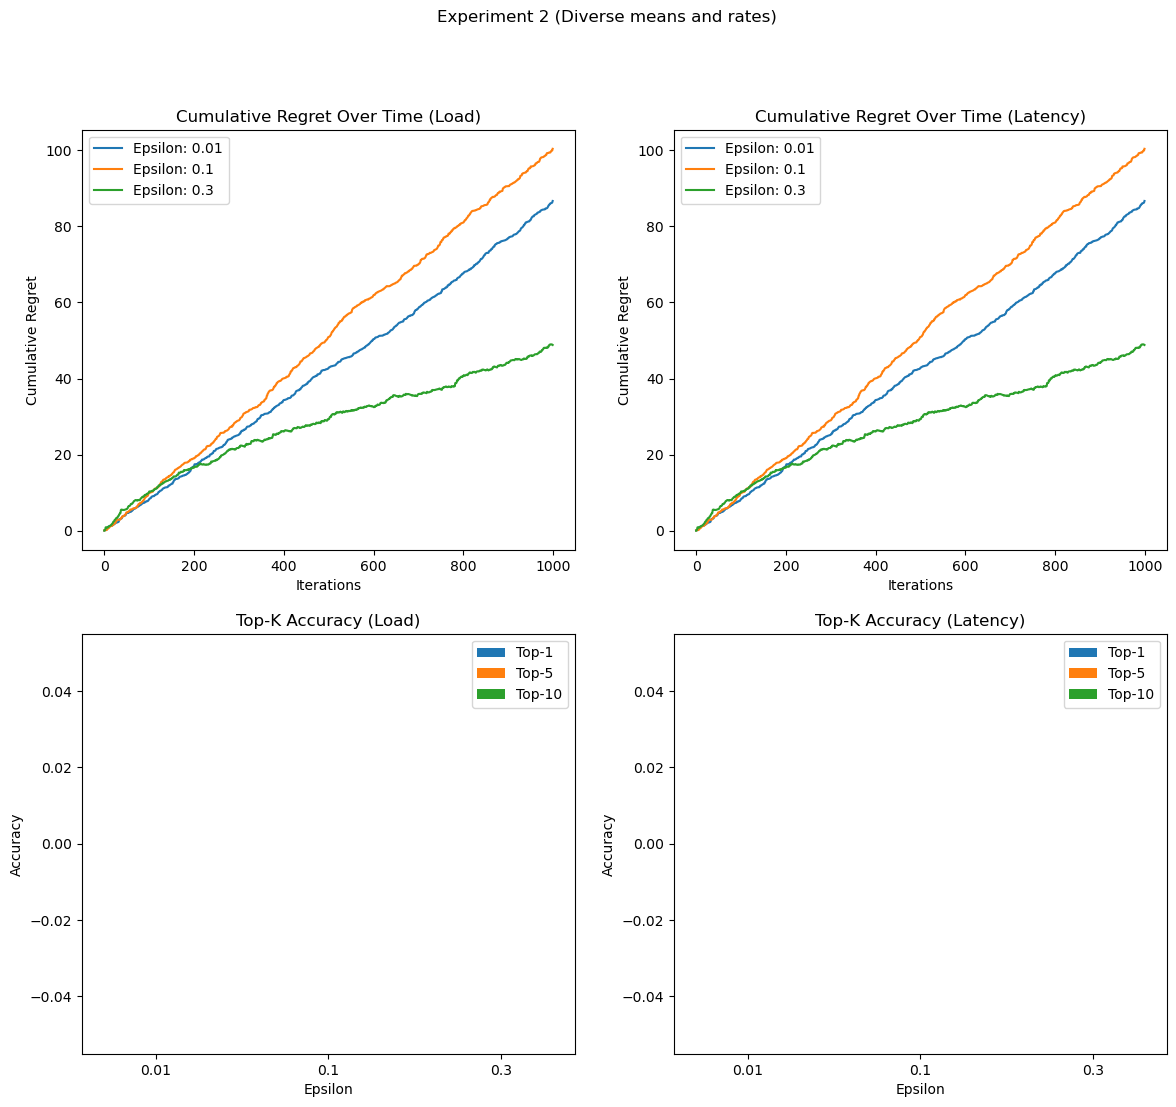

In [124]:
# Parameters
N = 10  # Number of nodes
T = 1000  # Number of samples per node
epsilon_values = [0.01, 0.1, 0.3]  # Different epsilon values for epsilon-greedy

# Experiment 1: Close means and rates
node_configs_exp1 = [{'mean_load': np.random.uniform(5, 6), 'stddev_load': np.random.uniform(0.5, 1), 'rate_latency': np.random.uniform(3, 3.1)} for _ in range(N)]

# Experiment 2: Diverse means and rates
node_configs_exp2 = [{'mean_load': np.random.uniform(5, 20), 'stddev_load': np.random.uniform(0.5, 1), 'rate_latency': np.random.uniform(3, 11)} for _ in range(N)]

# Run Experiment 1
experiment1 = Experiment(node_configs_exp1, epsilon_values, T)
experiment1.run()
print("Experiment 1 (Close means and rates):")
for epsilon, result in experiment1.results:
    print(f"Epsilon: {epsilon}, Results: {result}")
experiment1.plot_results("Experiment 1 (Close means and rates)")

# Run Experiment 2
experiment2 = Experiment(node_configs_exp2, epsilon_values, T)
experiment2.run()
print("\nExperiment 2 (Diverse means and rates):")
for epsilon, result in experiment2.results:
    print(f"Epsilon: {epsilon}, Results: {result}")
experiment2.plot_results("Experiment 2 (Diverse means and rates)")

In [125]:
import numpy as np
import matplotlib.pyplot as plt

class Node:
    def __init__(self, mean_load, stddev_load, rate_latency, T):
        self.mean_load = mean_load
        self.stddev_load = stddev_load
        self.rate_latency = rate_latency
        self.T = T
        self.load_data = np.random.normal(mean_load, stddev_load, T)
        self.latency_data = np.random.exponential(1 / rate_latency, T)

    def get_load_reward(self, t):
        load = self.load_data[t]
        return 1 / (1 + load)

    def get_latency_reward(self, t):
        latency = self.latency_data[t]
        alpha = 1  # Fixed alpha value = 1
        return np.exp(-alpha * latency)

    def expected_load_reward(self):  # Used to calculate the best rewards
        return 1 / (1 + self.mean_load)

    def expected_latency_reward(self):  # Used to calculate the best rewards
        return np.exp(-1 / self.rate_latency)


class EpsilonGreedyMAB:
    def __init__(self, nodes, epsilon):
        self.nodes = nodes
        self.epsilon = epsilon
        self.counts = np.zeros(len(nodes))
        self.cumulative_rewards = np.zeros(len(nodes))
        self.cumulative_regret = 0

    def select_node(self, t, reward_type, best_reward):
        if np.random.rand() < self.epsilon:
            node_index = np.random.choice(len(self.nodes))
        else:
            node_index = np.argmax(self.cumulative_rewards / (self.counts + 1e-10))

        if reward_type == "load":
            reward = self.nodes[node_index].get_load_reward(t)
        elif reward_type == "latency":
            reward = self.nodes[node_index].get_latency_reward(t)

        self.counts[node_index] += 1
        self.cumulative_rewards[node_index] += reward

        regret = best_reward - reward
        self.cumulative_regret += regret

        return node_index, reward, regret


class Experiment:
    def __init__(self, node_configs, epsilon_values, T):
        self.node_configs = node_configs
        self.epsilon_values = epsilon_values
        self.T = T
        self.nodes = self.generate_nodes()
        self.results = []

    def generate_nodes(self):
        return [Node(config['mean_load'], config['stddev_load'], config['rate_latency'], self.T) for config in self.node_configs]

    def run(self):
        for epsilon in self.epsilon_values:
            mab = EpsilonGreedyMAB(self.nodes, epsilon)

            selected_nodes_load = []
            selected_nodes_latency = []
            cumulative_regrets_load = np.zeros(self.T)
            cumulative_regrets_latency = np.zeros(self.T)

            best_reward_load = max([node.expected_load_reward() for node in self.nodes])
            best_reward_latency = max([node.expected_latency_reward() for node in self.nodes])

            for t in range(self.T):
                node_index_load, reward_load, regret_load = mab.select_node(t, "load", best_reward_load)
                node_index_latency, reward_latency, regret_latency = mab.select_node(t, "latency", best_reward_latency)

                selected_nodes_load.append(node_index_load)
                selected_nodes_latency.append(node_index_latency)
                cumulative_regrets_load[t] = mab.cumulative_regret
                cumulative_regrets_latency[t] = mab.cumulative_regret

            best_nodes_load = np.argsort([np.mean(node.load_data) for node in self.nodes])[:10]
            best_nodes_latency = np.argsort([np.mean(node.latency_data) for node in self.nodes])[:10]

            top1_accuracy_load = self.top_k_accuracy(selected_nodes_load, best_nodes_load, 1)
            top5_accuracy_load = self.top_k_accuracy(selected_nodes_load, best_nodes_load, 5)
            top10_accuracy_load = self.top_k_accuracy(selected_nodes_load, best_nodes_load, 10)

            top1_accuracy_latency = self.top_k_accuracy(selected_nodes_latency, best_nodes_latency, 1)
            top5_accuracy_latency = self.top_k_accuracy(selected_nodes_latency, best_nodes_latency, 5)
            top10_accuracy_latency = self.top_k_accuracy(selected_nodes_latency, best_nodes_latency, 10)

            self.results.append((epsilon, {
                "top1_load": top1_accuracy_load,
                "top5_load": top5_accuracy_load,
                "top10_load": top10_accuracy_load,
                "top1_latency": top1_accuracy_latency,
                "top5_latency": top5_accuracy_latency,
                "top10_latency": top10_accuracy_latency,
                "cumulative_regrets_load": cumulative_regrets_load,
                "cumulative_regrets_latency": cumulative_regrets_latency
            }))

    def top_k_accuracy(self, selected_nodes, best_nodes, k):
        top_k_selected = np.argsort(selected_nodes)[-k:]
        return len(set(top_k_selected).intersection(set(best_nodes))) / k

    def plot_results(self, title):
        fig, ax = plt.subplots(2, 2, figsize=(14, 12))

        for epsilon, result in self.results:
            cumulative_regrets_load = result['cumulative_regrets_load']
            ax[0, 0].plot(range(self.T), cumulative_regrets_load, label=f'Epsilon: {epsilon}')
        ax[0, 0].set_title("Cumulative Regret Over Time (Load)")
        ax[0, 0].set_xlabel("Iterations")
        ax[0, 0].set_ylabel("Cumulative Regret")
        ax[0, 0].legend()

        top1_load = [res[1]['top1_load'] for res in self.results]
        top5_load = [res[1]['top5_load'] for res in self.results]
        top10_load = [res[1]['top10_load'] for res in self.results]

        x = np.arange(len(self.epsilon_values))
        width = 0.2

        ax[1, 0].bar(x - width, top1_load, width, label='Top-1')
        ax[1, 0].bar(x, top5_load, width, label='Top-5')
        ax[1, 0].bar(x + width, top10_load, width, label='Top-10')

        ax[1, 0].set_title("Top-K Accuracy (Load)")
        ax[1, 0].set_xlabel("Epsilon")
        ax[1, 0].set_ylabel("Accuracy")
        ax[1, 0].set_xticks(x)
        ax[1, 0].set_xticklabels([str(e) for e in self.epsilon_values])
        ax[1, 0].legend()

        for epsilon, result in self.results:
            cumulative_regrets_latency = result['cumulative_regrets_latency']
            ax[0, 1].plot(range(self.T), cumulative_regrets_latency, label=f'Epsilon: {epsilon}')
        ax[0, 1].set_title("Cumulative Regret Over Time (Latency)")
        ax[0, 1].set_xlabel("Iterations")
        ax[0, 1].set_ylabel("Cumulative Regret")
        ax[0, 1].legend()

        top1_latency = [res[1]['top1_latency'] for res in self.results]
        top5_latency = [res[1]['top5_latency'] for res in self.results]
        top10_latency = [res[1]['top10_latency'] for res in self.results]

        ax[1, 1].bar(x - width, top1_latency, width, label='Top-1')
        ax[1, 1].bar(x, top5_latency, width, label='Top-5')
        ax[1, 1].bar(x + width, top10_latency, width, label='Top-10')

        ax


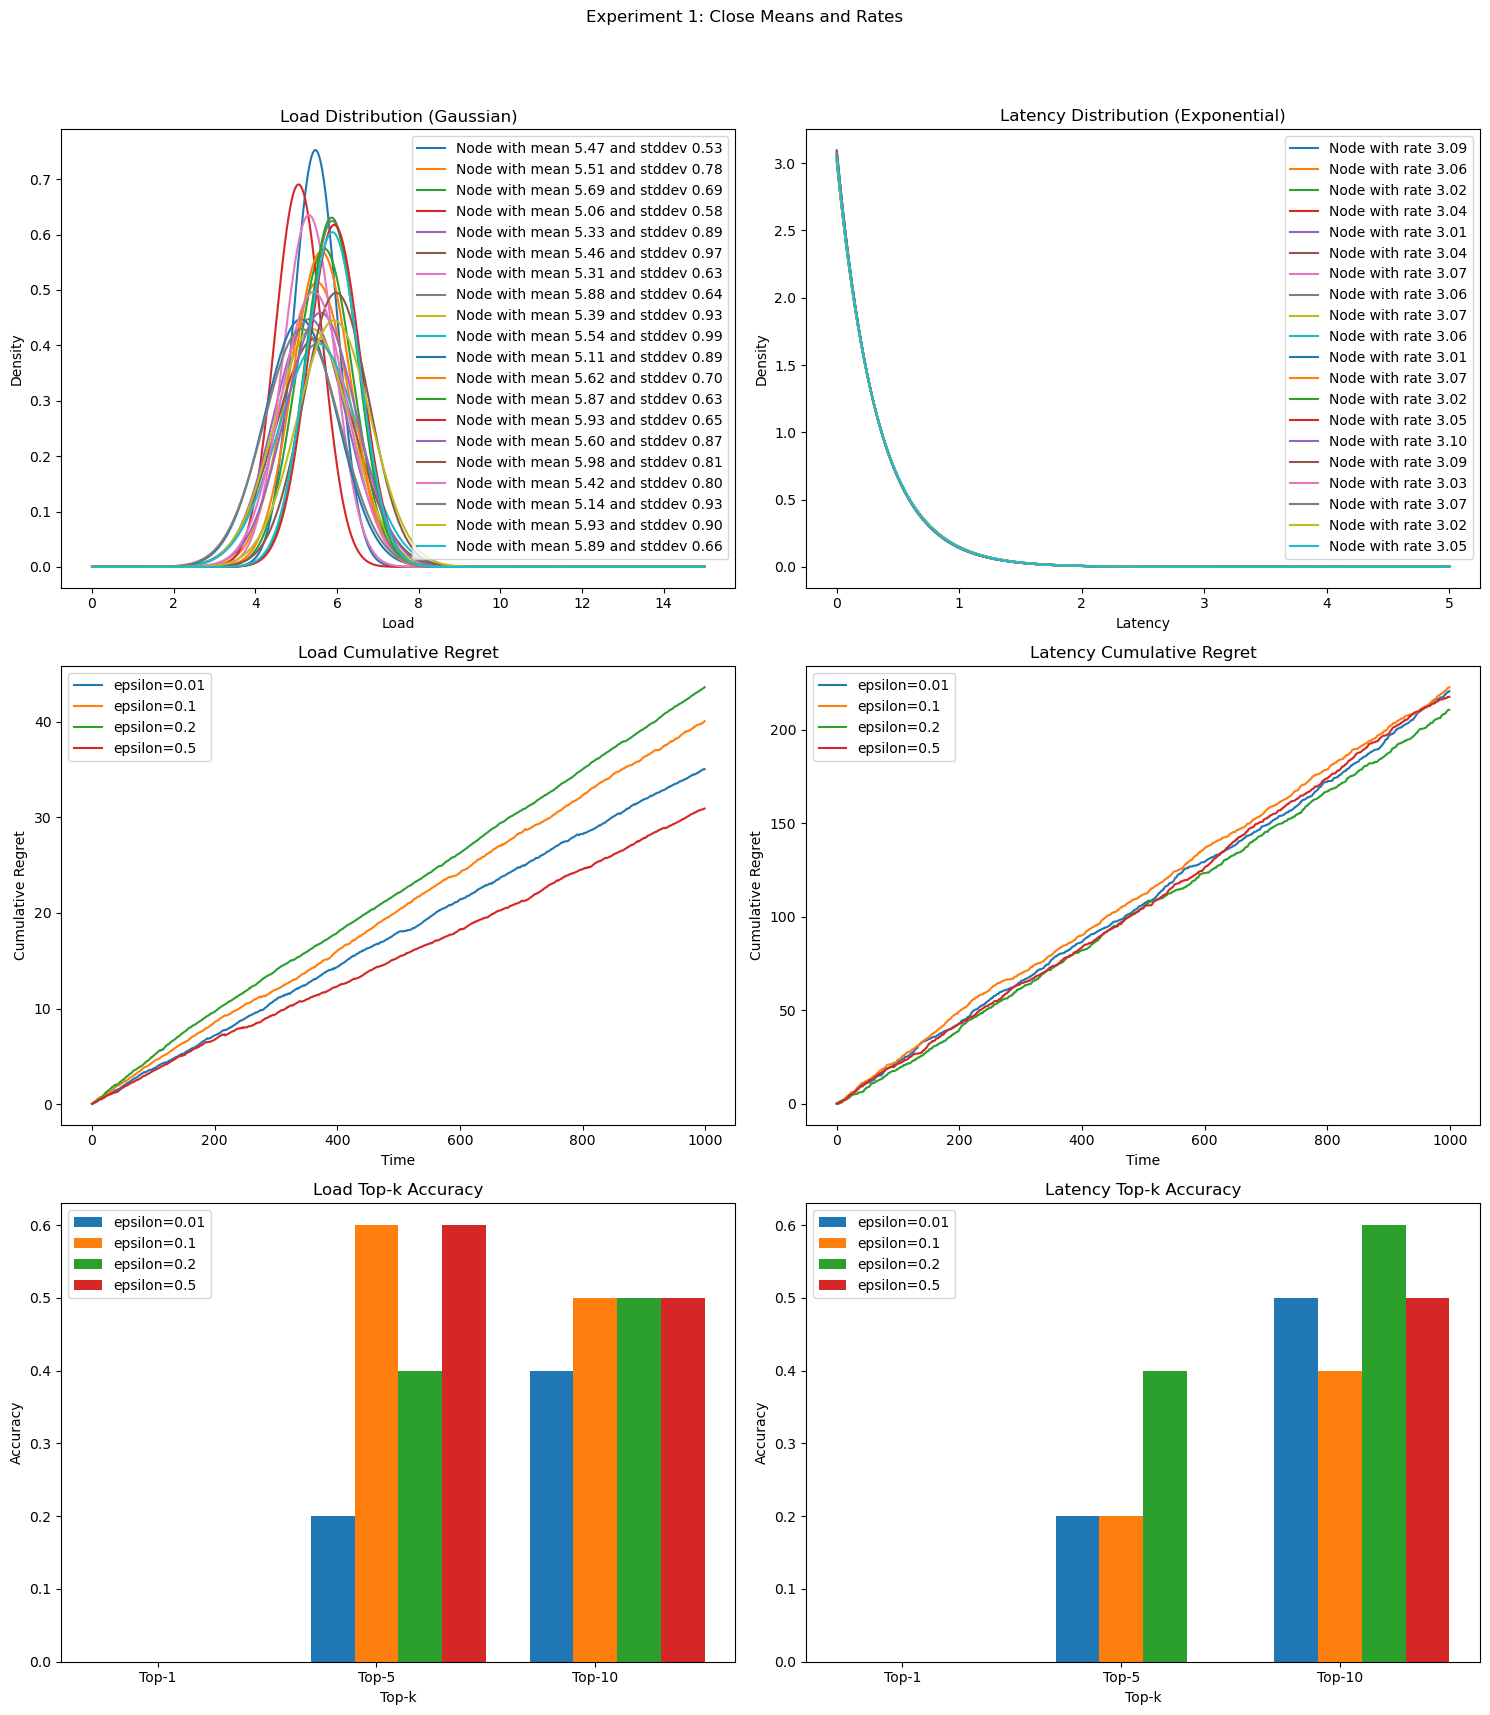

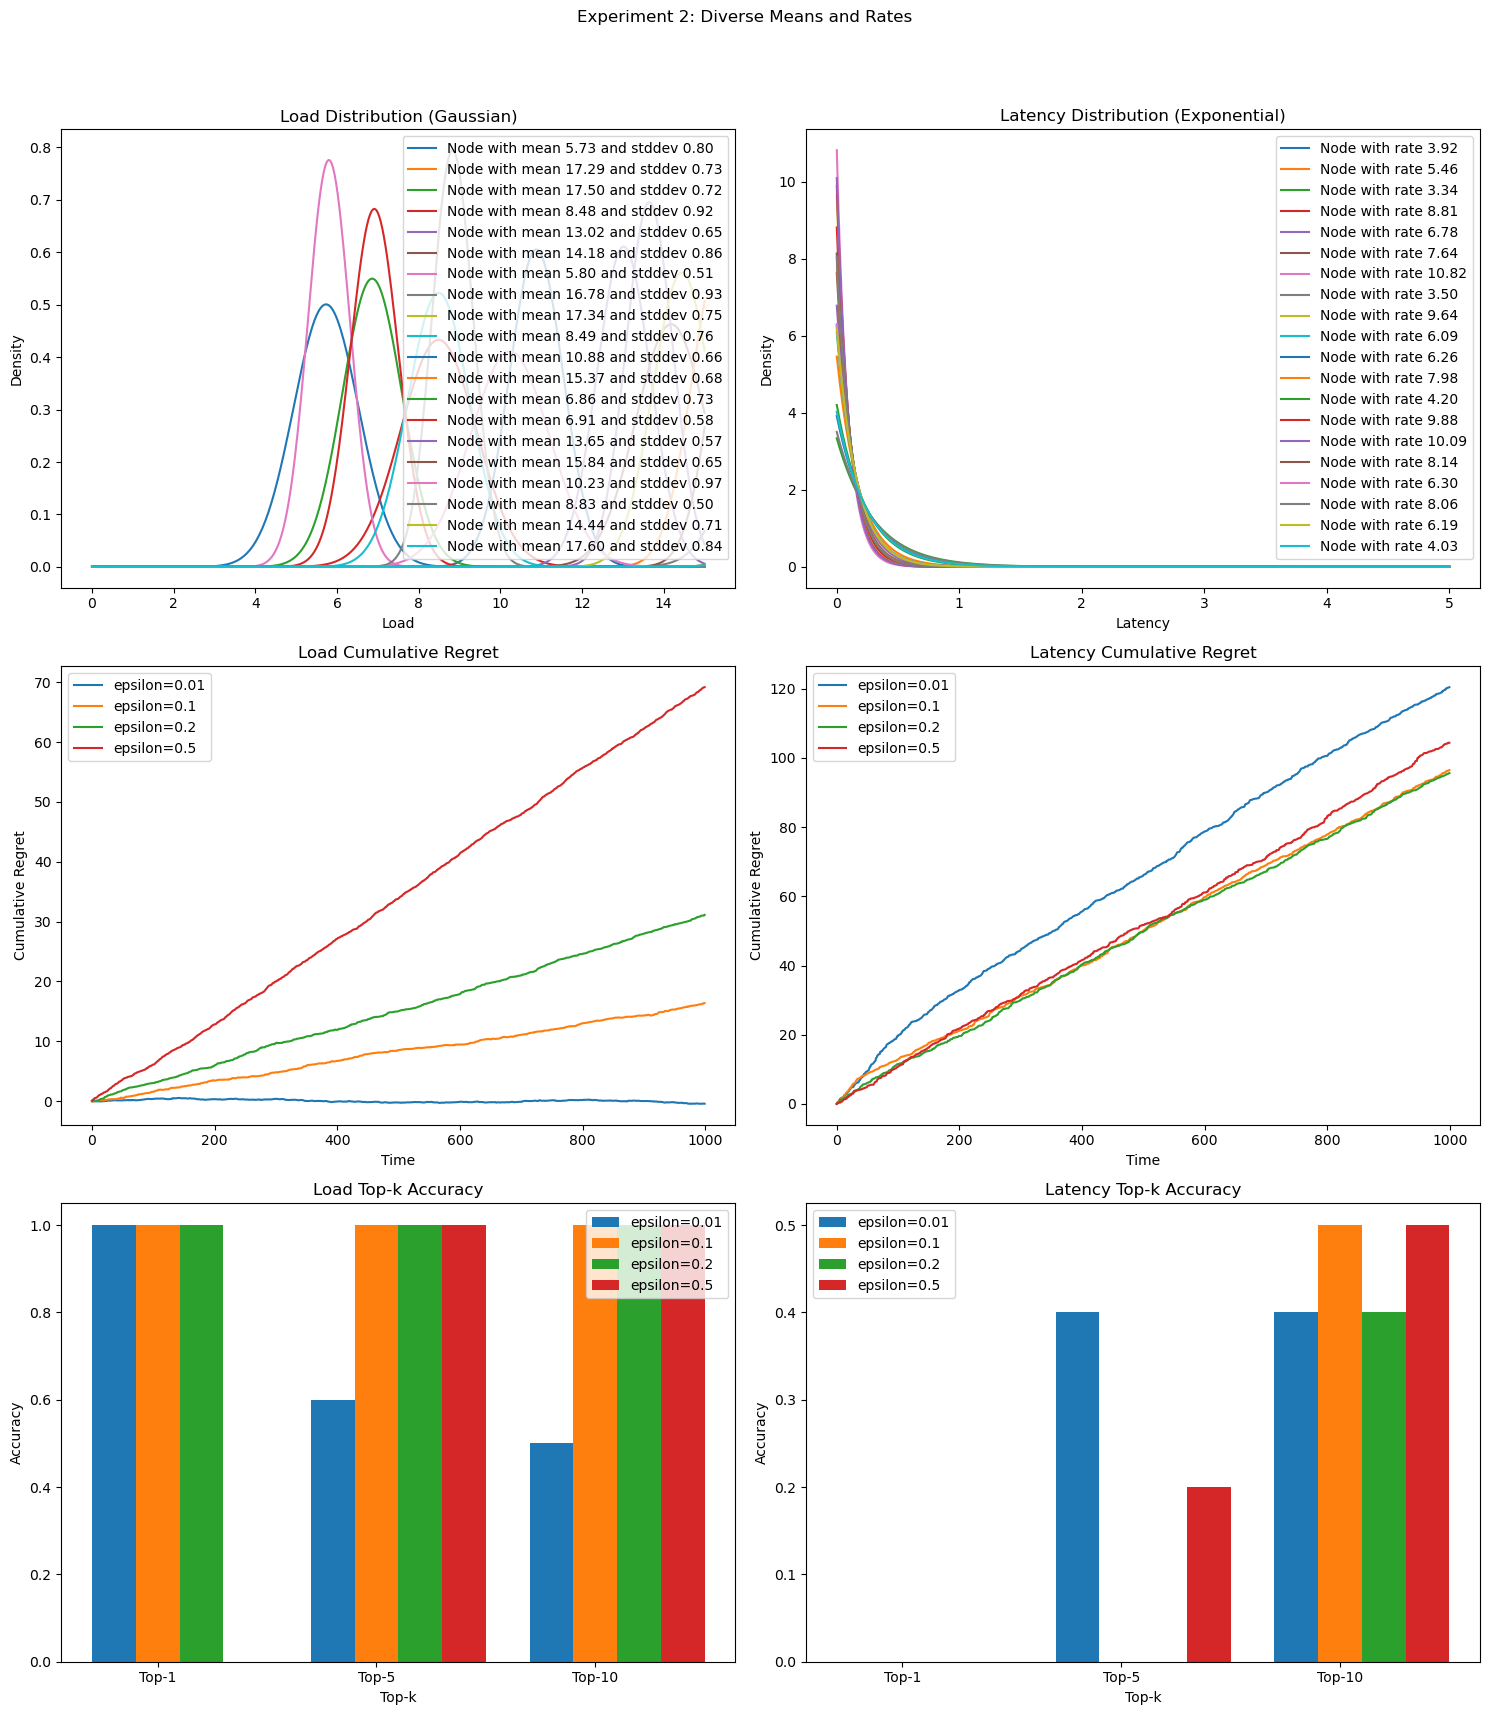

In [126]:
import numpy as np
import matplotlib.pyplot as plt

class Node:
    def __init__(self, mean_load, stddev_load, rate_latency):
        self.mean_load = mean_load
        self.stddev_load = stddev_load
        self.rate_latency = rate_latency

    def sample_load(self):
        return np.random.normal(self.mean_load, self.stddev_load)

    def sample_latency(self):
        return np.random.exponential(1 / self.rate_latency)

class EpsilonGreedyMAB:
    def __init__(self, nodes, epsilon):
        self.nodes = nodes
        self.epsilon = epsilon
        self.counts = np.zeros(len(nodes))  # Number of times each node was selected
        self.ave_reward = np.zeros(len(nodes))  # Average reward for each node
        self.regret = []  # Cumulative regret over time

    def select_node(self):
        # Epsilon-greedy selection
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.nodes))  # Randomly select a node
        else:
            return np.argmax(self.ave_reward)  # Select the node with the highest average reward

    def update(self, chosen_node, reward):
        # Update the average reward of the chosen node
        self.counts[chosen_node] += 1
        n = self.counts[chosen_node]
        value = self.ave_reward[chosen_node]
        self.ave_reward[chosen_node] = ((n - 1) / n) * value + (1 / n) * reward  # upgdate the average reward without storing all rewards

    def run(self, T, reward_function):
        # Run the multi-armed bandit algorithm for T time steps
        total_regret = 0
        optimal_reward = max([reward_function(node) for node in self.nodes])  # calculate the optimal reward
        for t in range(T):
            chosen_node = self.select_node()
            reward = reward_function(self.nodes[chosen_node])
            regret = optimal_reward - reward
            total_regret += regret
            self.regret.append(total_regret)
            self.update(chosen_node, reward)

class Experiment:
    def __init__(self, node_configs):
        self.nodes = [Node(**config) for config in node_configs]  # Create nodes based on configurations

    def run(self, T, epsilon_values, reward_function):
        # Run the experiment for different epsilon values
        results = {}
        for epsilon in epsilon_values:
            mab = EpsilonGreedyMAB(self.nodes, epsilon)
            mab.run(T, reward_function)
            results[epsilon] = {
                'regret': mab.regret,
                'values': mab.ave_reward
            }
        return results, self.nodes

def reward_function_load(node):
    load = node.sample_load()
    return 1 / (1 + load)

def reward_function_latency(node):
    latency = node.sample_latency()
    alpha = 1  # Fixed alpha value = 1
    return np.exp(-alpha * latency)

def calculate_top_k_accuracy(results, nodes, k_values, reward_function):
    # Calculate the top-k accuracy for different epsilon values
    accuracies = {epsilon: [] for epsilon in results}
    optimal_values = np.array([reward_function(node) for node in nodes])
    for k in k_values:
        for epsilon, result in results.items():
            top_k_nodes = np.argsort(result['values'])[-k:]
            optimal_nodes = np.argsort(optimal_values)[-k:]
            accuracy = len(set(top_k_nodes) & set(optimal_nodes)) / k
            accuracies[epsilon].append(accuracy)
    return accuracies

def plot_experiment(results_load, results_latency, nodes, k_values, experiment_title):
    fig, axs = plt.subplots(3, 2, figsize=(15, 18))

    # Plotting the load distribution
    x = np.linspace(0, 15, 400)
    for node in nodes:
        y = norm.pdf(x, node.mean_load, node.stddev_load)
        axs[0, 0].plot(x, y, label=f'Node with mean {node.mean_load:.2f} and stddev {node.stddev_load:.2f}')
    axs[0, 0].set_title('Load Distribution (Gaussian)')
    axs[0, 0].set_xlabel('Load')
    axs[0, 0].set_ylabel('Density')
    axs[0, 0].legend(loc='upper right')
    
    # Plotting the delay distribution
    x = np.linspace(0, 5, 400)
    for node in nodes:
        y = expon.pdf(x, scale=1/node.rate_latency)
        axs[0, 1].plot(x, y, label=f'Node with rate {node.rate_latency:.2f}')
    axs[0, 1].set_title('Latency Distribution (Exponential)')
    axs[0, 1].set_xlabel('Latency')
    axs[0, 1].set_ylabel('Density')
    axs[0, 1].legend(loc='upper right')

    # Plotting load accumulation regrets
    for epsilon, result in results_load.items():
        axs[1, 0].plot(result['regret'], label=f'epsilon={epsilon}')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Cumulative Regret')
    axs[1, 0].set_title('Load Cumulative Regret')
    axs[1, 0].legend()

    # Plotting load top-k accuracy
    accuracies_load = calculate_top_k_accuracy(results_load, nodes, k_values, reward_function_load)
    x = np.arange(len(k_values))
    width = 0.2
    for i, (epsilon, accuracy) in enumerate(accuracies_load.items()):
        axs[2, 0].bar(x + i * width, accuracy, width, label=f'epsilon={epsilon}')
    axs[2, 0].set_xlabel('Top-k')
    axs[2, 0].set_ylabel('Accuracy')
    axs[2, 0].set_title('Load Top-k Accuracy')
    axs[2, 0].set_xticks(x + width)
    axs[2, 0].set_xticklabels([f'Top-{k}' for k in k_values])
    axs[2, 0].legend()

    # Plot latency cumulative regret
    for epsilon, result in results_latency.items():
        axs[1, 1].plot(result['regret'], label=f'epsilon={epsilon}')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Cumulative Regret')
    axs[1, 1].set_title('Latency Cumulative Regret')
    axs[1, 1].legend()

    # Plot latency top-k accuracy
    accuracies_latency = calculate_top_k_accuracy(results_latency, nodes, k_values, reward_function_latency)
    x = np.arange(len(k_values))
    width = 0.2
    for i, (epsilon, accuracy) in enumerate(accuracies_latency.items()):
        axs[2, 1].bar(x + i * width, accuracy, width, label=f'epsilon={epsilon}')
    axs[2, 1].set_xlabel('Top-k')
    axs[2, 1].set_ylabel('Accuracy')
    axs[2, 1].set_title('Latency Top-k Accuracy')
    axs[2, 1].set_xticks(x + width)
    axs[2, 1].set_xticklabels([f'Top-{k}' for k in k_values])
    axs[2, 1].legend()

    fig.suptitle(experiment_title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Set parameters
N = 20
T = 1000
epsilon_values = [0.01, 0.1, 0.2, 0.5]
k_values = [1, 5, 10]

# Experiment 1: Close means and rates
node_configs_exp1 = [{'mean_load': np.random.uniform(5, 6), 'stddev_load': np.random.uniform(0.5, 1), 'rate_latency': np.random.uniform(3, 3.1)} for _ in range(N)]

# Experiment 2: Diverse means and rates
node_configs_exp2 = [{'mean_load': np.random.uniform(5, 20), 'stddev_load': np.random.uniform(0.5, 1), 'rate_latency': np.random.uniform(3, 11)} for _ in range(N)]

# Run experiments
experiment1 = Experiment(node_configs_exp1)
experiment2 = Experiment(node_configs_exp2)

results_exp1_load, nodes_exp1 = experiment1.run(T, epsilon_values, reward_function_load)
results_exp1_latency, _ = experiment1.run(T, epsilon_values, reward_function_latency)
results_exp2_load, nodes_exp2 = experiment2.run(T, epsilon_values, reward_function_load)
results_exp2_latency, _ = experiment2.run(T, epsilon_values, reward_function_latency)

# Plot results for Experiment 1
plot_experiment(results_exp1_load, results_exp1_latency, nodes_exp1, k_values, 'Experiment 1: Close Means and Rates')

# Plot results for Experiment 2
plot_experiment(results_exp2_load, results_exp2_latency, nodes_exp2, k_values, 'Experiment 2: Diverse Means and Rates')


Debug: total_regret < 0 at time 784, regret=-0.04313178001473353, optimal_reward=0.14927249490714772, reward=0.19240427492188125
Debug: total_regret < 0 at time 785, regret=-0.010090260845219218, optimal_reward=0.14927249490714772, reward=0.15936275575236694
Debug: total_regret < 0 at time 786, regret=-0.01641735423164764, optimal_reward=0.14927249490714772, reward=0.16568984913879536
Debug: total_regret < 0 at time 787, regret=-0.01162733567049784, optimal_reward=0.14927249490714772, reward=0.16089983057764556
Debug: total_regret < 0 at time 789, regret=-0.032930262059150006, optimal_reward=0.14927249490714772, reward=0.18220275696629773
Debug: total_regret < 0 at time 790, regret=-0.01439718685156538, optimal_reward=0.14927249490714772, reward=0.1636696817587131
Debug: total_regret < 0 at time 791, regret=-0.024787883133386673, optimal_reward=0.14927249490714772, reward=0.1740603780405344
Debug: total_regret < 0 at time 792, regret=-0.006236259387426751, optimal_reward=0.149272494907

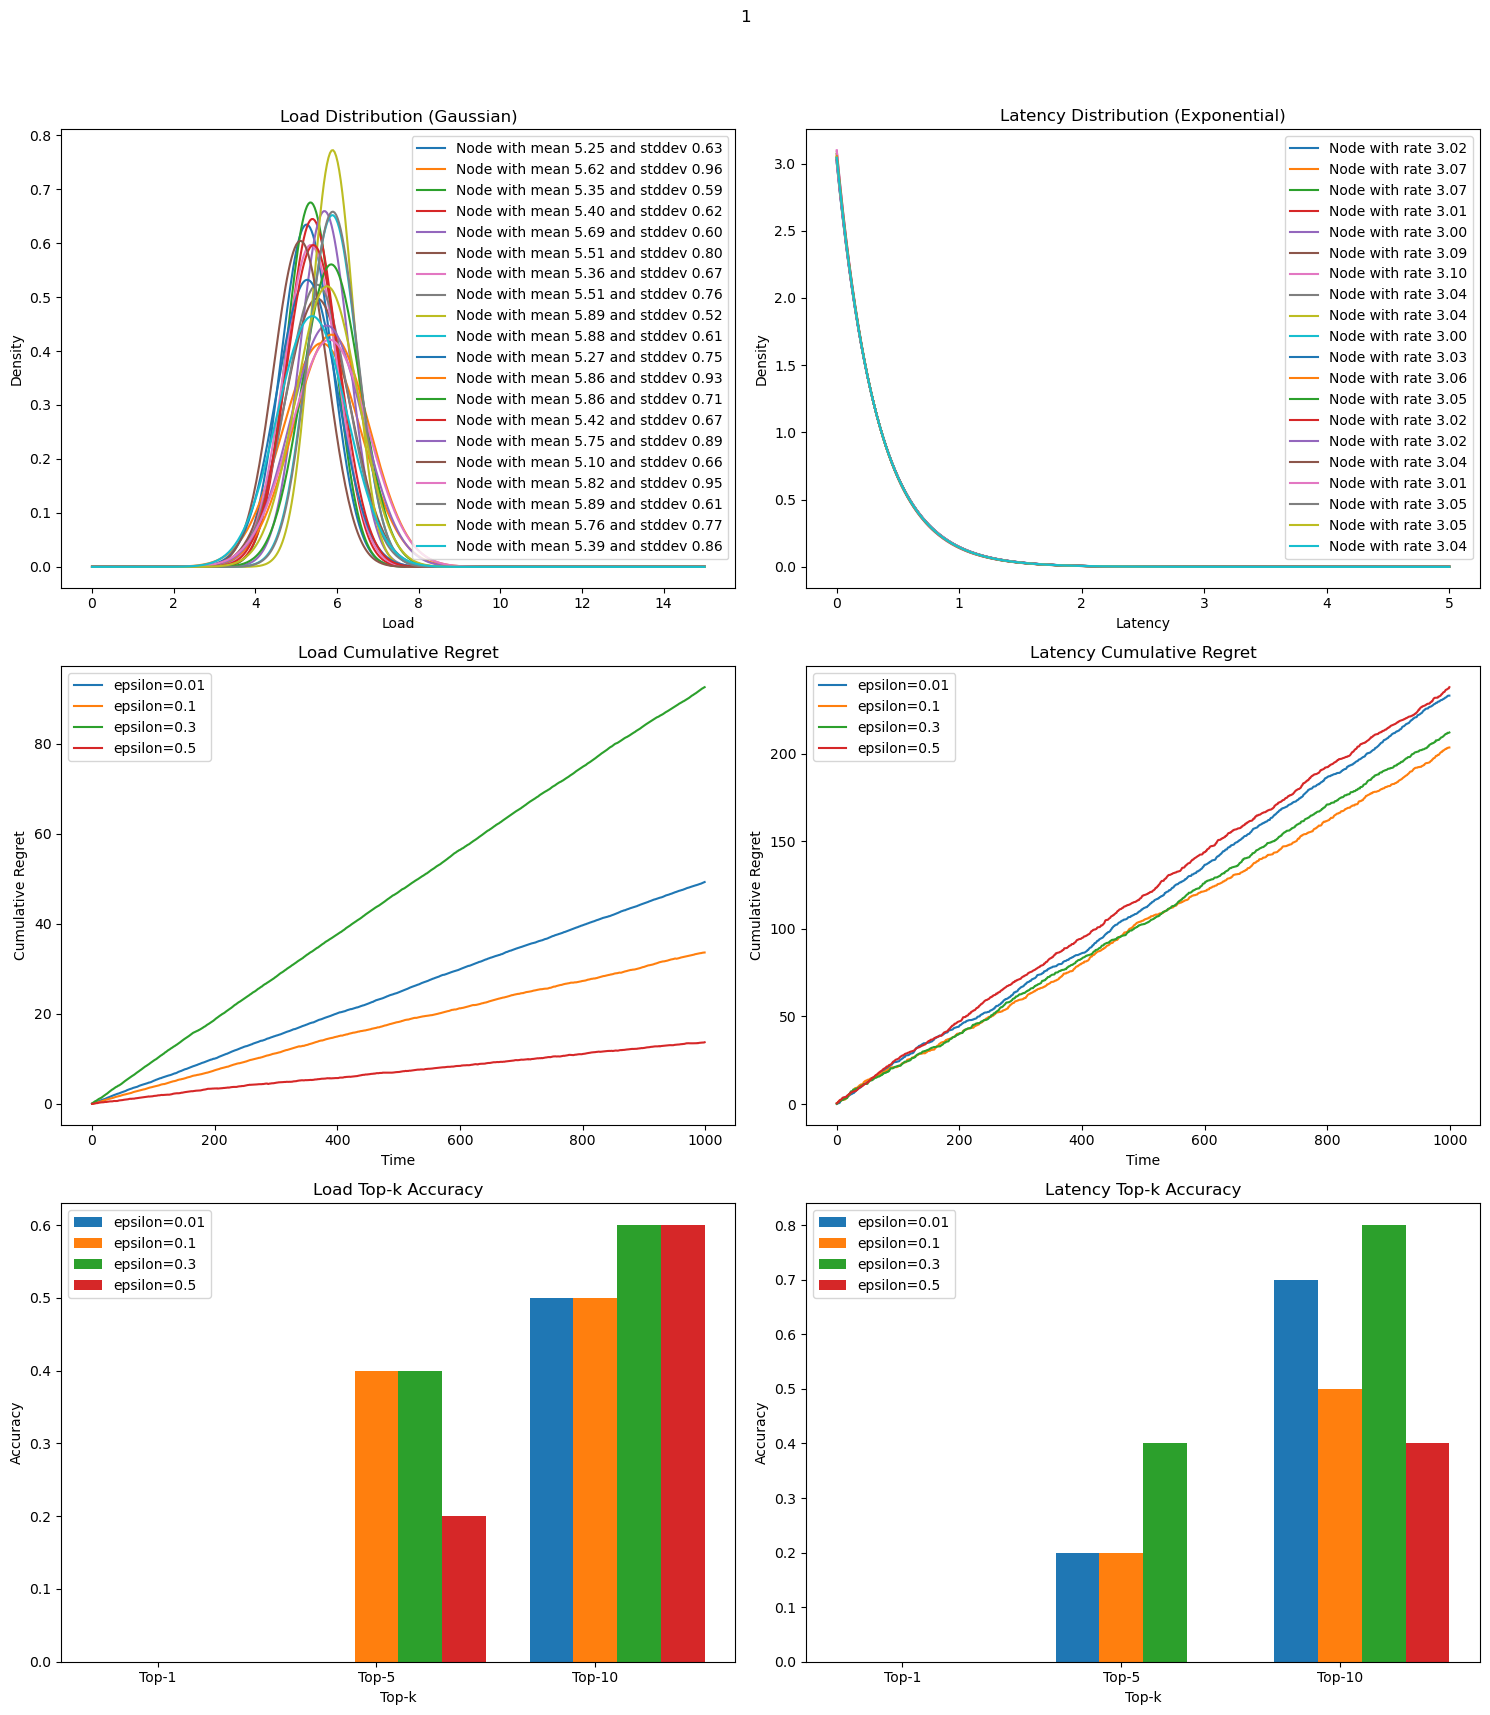

Debug: Accuracy dropped for epsilon=0.1, k=5, previous_k=1, accuracy=0.8, previous_accuracy=1.0
Debug: Accuracy dropped for epsilon=0.3, k=5, previous_k=1, accuracy=0.8, previous_accuracy=1.0
Debug: Accuracy dropped for epsilon=0.5, k=5, previous_k=1, accuracy=0.8, previous_accuracy=1.0


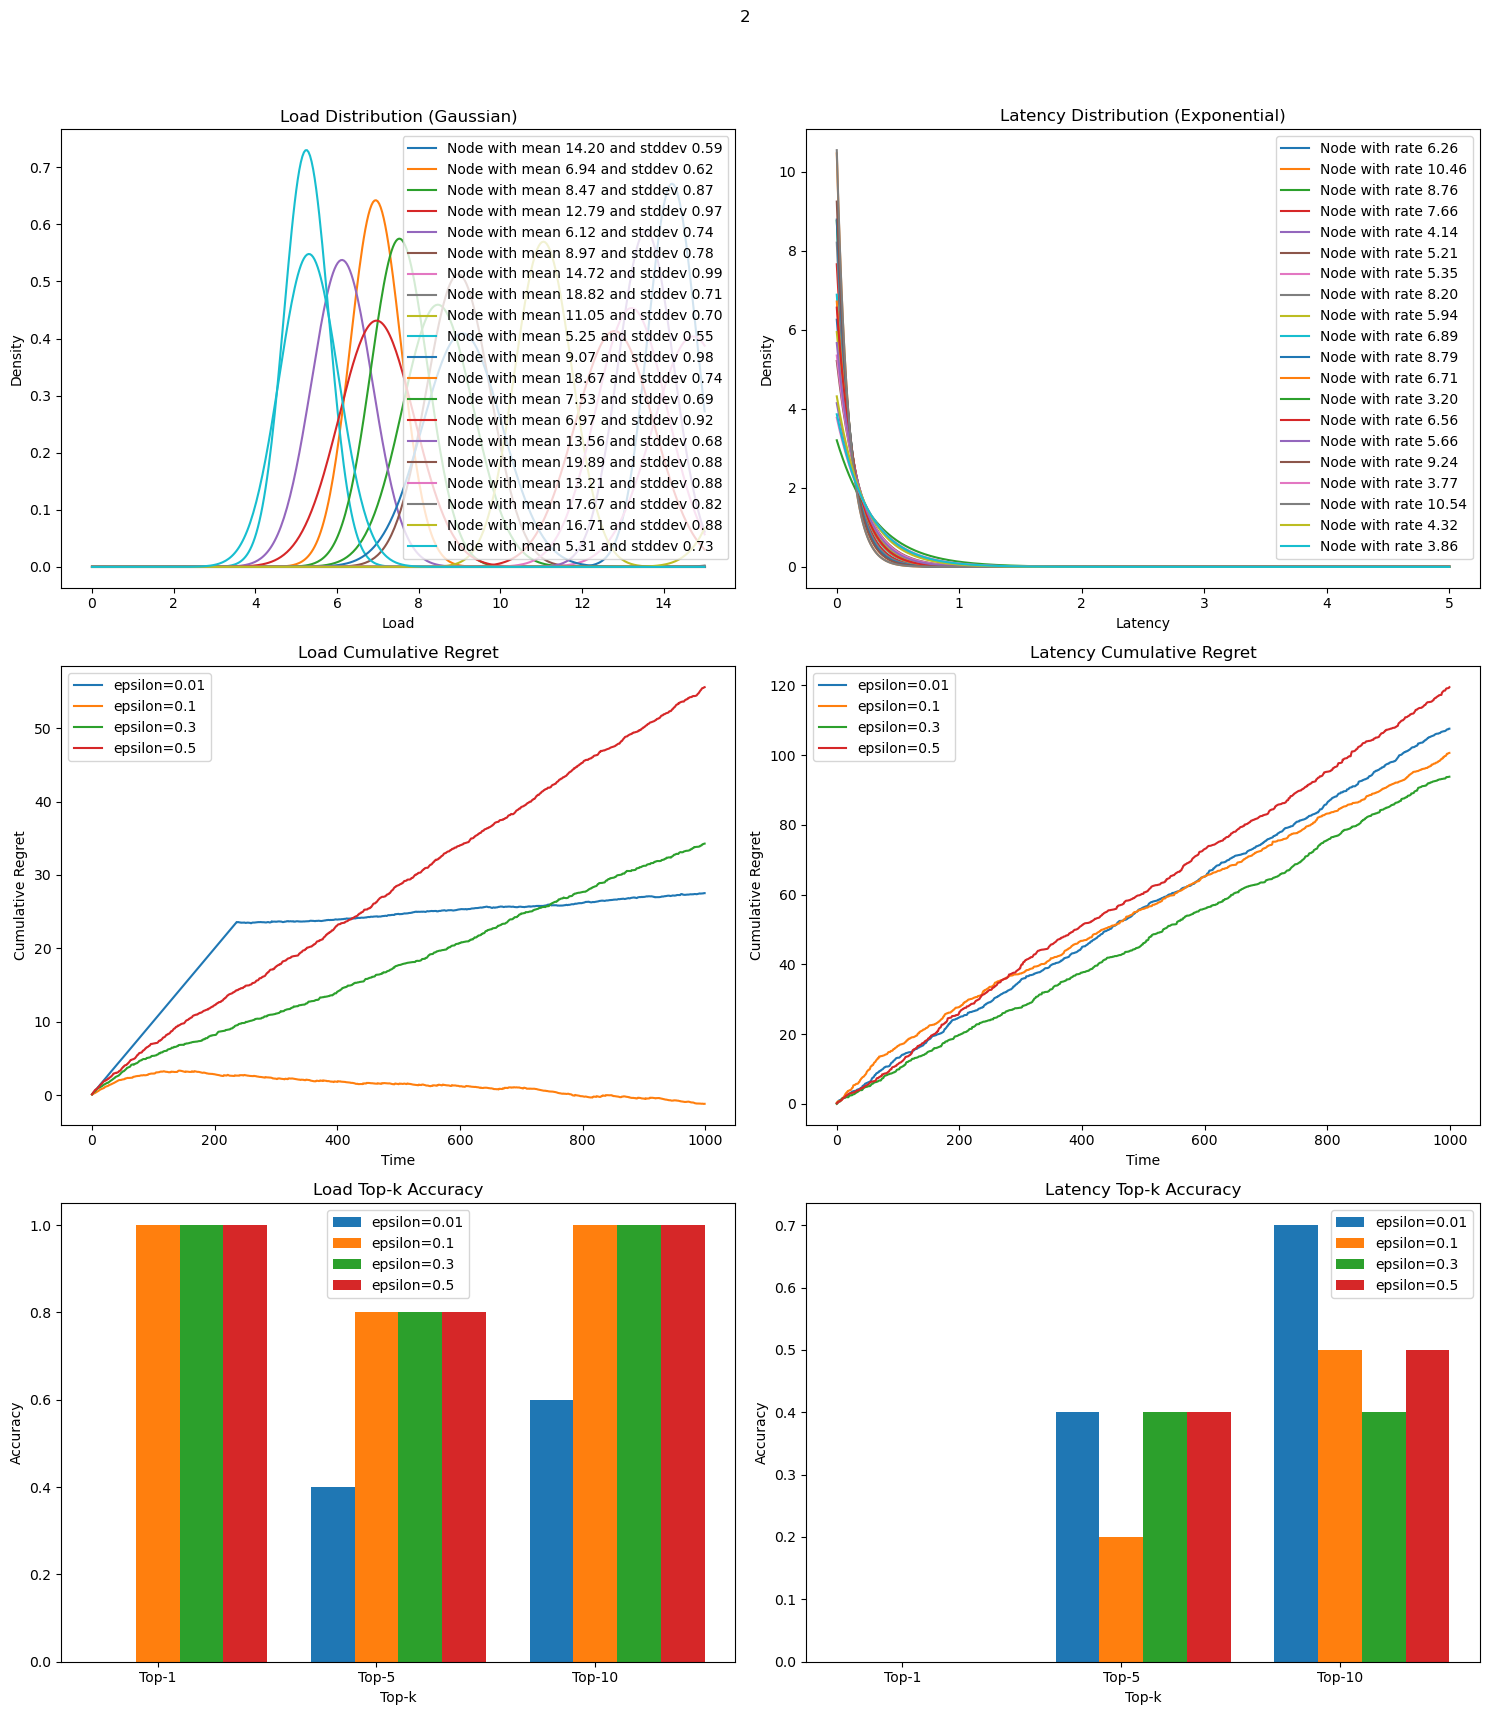

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

class Node:
    def __init__(self, mean_load, stddev_load, rate_latency):
        self.mean_load = mean_load  # 节点负载的均值
        self.stddev_load = stddev_load  # 节点负载的标准差
        self.rate_latency = rate_latency  # 节点延迟的速率

    def sample_load(self):
        # 从正态分布中采样负载值
        return np.random.normal(self.mean_load, self.stddev_load)

    def sample_latency(self):
        # 从指数分布中采样延迟值
        return np.random.exponential(1 / self.rate_latency)

class EpsilonGreedyMAB:
    def __init__(self, nodes, epsilon):
        self.nodes = nodes  # 节点列表
        self.epsilon = epsilon  # 探索概率
        self.counts = np.zeros(len(nodes))  # 每个节点被选择的次数
        self.values = np.zeros(len(nodes))  # 每个节点的平均奖励值
        self.regret = []  # 累积遗憾列表

    def select_node(self):
        # 根据epsilon-greedy策略选择节点
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.nodes))  # 随机选择
        else:
            return np.argmax(self.values)  # 选择平均奖励最高的节点

    def update(self, chosen_node, reward):
        # 更新选定节点的平均奖励值
        self.counts[chosen_node] += 1
        n = self.counts[chosen_node]
        value = self.values[chosen_node]
        self.values[chosen_node] = ((n - 1) / n) * value + (1 / n) * reward

    def run(self, T, reward_function):
        total_regret = 0
        optimal_reward = max([reward_function(node) for node in self.nodes])  # 计算最优奖励
        for t in range(T):
            chosen_node = self.select_node()  # 选择节点
            reward = reward_function(self.nodes[chosen_node])  # 计算奖励
            regret = optimal_reward - reward  # 计算遗憾
            total_regret += regret
            if total_regret < 0:
                print(f"Debug: total_regret < 0 at time {t}, regret={regret}, optimal_reward={optimal_reward}, reward={reward}")
            self.regret.append(total_regret)  # 记录累积遗憾
            self.update(chosen_node, reward)  # 更新节点信息

class Experiment:
    def __init__(self, node_configs):
        self.nodes = [Node(**config) for config in node_configs]  # 创建节点实例

    def run(self, T, epsilon_values, reward_function):
        # 运行实验，遍历不同的epsilon值
        results = {}
        for epsilon in epsilon_values:
            mab = EpsilonGreedyMAB(self.nodes, epsilon)  # 创建多臂老虎机实例
            mab.run(T, reward_function)  # 运行算法
            results[epsilon] = {
                'regret': mab.regret,
                'values': mab.values
            }
        return results, self.nodes  # 返回结果和节点

def reward_function_load(node):
    load = node.sample_load()
    return 1 / (1 + load)  # 计算奖励

def reward_function_latency(node):
    latency = node.sample_latency()
    return np.exp(-latency)  # 计算奖励

def calculate_top_k_accuracy(results, nodes, k_values, reward_function):
    accuracies = {epsilon: [] for epsilon in results}
    optimal_values = np.array([reward_function(node) for node in nodes])
    for k in k_values:
        for epsilon, result in results.items():
            top_k_nodes = np.argsort(result['values'])[-k:]
            optimal_nodes = np.argsort(optimal_values)[-k:]
            accuracy = len(set(top_k_nodes) & set(optimal_nodes)) / k
            if k > 1:  # Ensure that k > 1 for meaningful comparison
                previous_k = k_values[k_values.index(k) - 1]
                previous_accuracy = len(set(np.argsort(result['values'])[-previous_k:]) & set(np.argsort(optimal_values)[-previous_k:])) / previous_k
                if accuracy < previous_accuracy:
                    print(f"Debug: Accuracy dropped for epsilon={epsilon}, k={k}, previous_k={previous_k}, accuracy={accuracy}, previous_accuracy={previous_accuracy}")
            accuracies[epsilon].append(accuracy)
    return accuracies

def plot_experiment(results_load, results_latency, nodes, k_values, experiment_title):
    fig, axs = plt.subplots(3, 2, figsize=(15, 18))

    # 绘制负载分布（高斯分布）
    x = np.linspace(0, 15, 400)
    for node in nodes:
        y = norm.pdf(x, node.mean_load, node.stddev_load)
        axs[0, 0].plot(x, y, label=f'Node with mean {node.mean_load:.2f} and stddev {node.stddev_load:.2f}')
    axs[0, 0].set_title('Load Distribution (Gaussian)')
    axs[0, 0].set_xlabel('Load')
    axs[0, 0].set_ylabel('Density')
    axs[0, 0].legend(loc='upper right')

    # 绘制延迟分布（指数分布）
    x = np.linspace(0, 5, 400)
    for node in nodes:
        y = expon.pdf(x, scale=1/node.rate_latency)
        axs[0, 1].plot(x, y, label=f'Node with rate {node.rate_latency:.2f}')
    axs[0, 1].set_title('Latency Distribution (Exponential)')
    axs[0, 1].set_xlabel('Latency')
    axs[0, 1].set_ylabel('Density')
    axs[0, 1].legend(loc='upper right')

    # 绘制负载累积遗憾
    for epsilon, result in results_load.items():
        axs[1, 0].plot(result['regret'], label=f'epsilon={epsilon}')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Cumulative Regret')
    axs[1, 0].set_title('Load Cumulative Regret')
    axs[1, 0].legend()

    # 计算并绘制负载top-k准确率
    accuracies_load = calculate_top_k_accuracy(results_load, nodes, k_values, reward_function_load)
    x = np.arange(len(k_values))
    width = 0.2
    for i, (epsilon, accuracy) in enumerate(accuracies_load.items()):
        axs[2, 0].bar(x + i * width, accuracy, width, label=f'epsilon={epsilon}')
    axs[2, 0].set_xlabel('Top-k')
    axs[2, 0].set_ylabel('Accuracy')
    axs[2, 0].set_title('Load Top-k Accuracy')
    axs[2, 0].set_xticks(x + width)
    axs[2, 0].set_xticklabels([f'Top-{k}' for k in k_values])
    axs[2, 0].legend()

    # 绘制延迟累积遗憾
    for epsilon, result in results_latency.items():
        axs[1, 1].plot(result['regret'], label=f'epsilon={epsilon}')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('Cumulative Regret')
    axs[1, 1].set_title('Latency Cumulative Regret')
    axs[1, 1].legend()

    # 计算并绘制延迟top-k准确率
    accuracies_latency = calculate_top_k_accuracy(results_latency, nodes, k_values, reward_function_latency)
    x = np.arange(len(k_values))
    width = 0.2
    for i, (epsilon, accuracy) in enumerate(accuracies_latency.items()):
        axs[2, 1].bar(x + i * width, accuracy, width, label=f'epsilon={epsilon}')
    axs[2, 1].set_xlabel('Top-k')
    axs[2, 1].set_ylabel('Accuracy')
    axs[2, 1].set_title('Latency Top-k Accuracy')
    axs[2, 1].set_xticks(x + width)
    axs[2, 1].set_xticklabels([f'Top-{k}' for k in k_values])
    axs[2, 1].legend()

    fig.suptitle(experiment_title)  # 设置实验标题
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局
    plt.show()  # 显示图像

# 设置参数
N = 20
T = 1000
epsilon_values = [0.01, 0.1, 0.3, 0.5]
k_values = [1, 5, 10]

# 实验1：相近的均值和速率
node_configs_exp1 = [{'mean_load': np.random.uniform(5, 6), 'stddev_load': np.random.uniform(0.5, 1), 'rate_latency': np.random.uniform(3, 3.1)} for _ in range(N)]

# 实验2：不同的均值和速率
node_configs_exp2 = [{'mean_load': np.random.uniform(5, 20), 'stddev_load': np.random.uniform(0.5, 1), 'rate_latency': np.random.uniform(3, 11)} for _ in range(N)]

# 运行实验
experiment1 = Experiment(node_configs_exp1)
experiment2 = Experiment(node_configs_exp2)

results_exp1_load, nodes_exp1 = experiment1.run(T, epsilon_values, reward_function_load)
results_exp1_latency, _ = experiment1.run(T, epsilon_values, reward_function_latency)
results_exp2_load, nodes_exp2 = experiment2.run(T, epsilon_values, reward_function_load)
results_exp2_latency, _ = experiment2.run(T, epsilon_values, reward_function_latency)

# 绘制实验1的结果
plot_experiment(results_exp1_load, results_exp1_latency, nodes_exp1, k_values, '1')

# 绘制实验2的结果
plot_experiment(results_exp2_load, results_exp2_latency, nodes_exp2, k_values, '2')


In [128]:
import numpy as np

# 参数设置
N = 20  # 节点数
T = 1000  # 时间步数
epsilon = 0.1  # epsilon-greedy 算法中的epsilon值

# 初始化每个节点的负载分布参数（均值和标准差）
means = np.random.uniform(0, 10, N)  # 均值在0到10之间的均匀分布
stds = np.random.uniform(1, 2, N)  # 标准差在1到2之间的均匀分布

# 初始化奖励记录
Q = np.zeros(N)  # 累计奖励
N_j = np.zeros(N)  # 选择次数

# 记录选择的节点和对应的奖励
choices = []
rewards = []

# epsilon-greedy 算法
for t in range(T):
    if np.random.rand() < epsilon:
        # 随机选择一个节点
        j = np.random.randint(0, N)
    else:
        # 选择当前累计奖励最大的节点
        j = np.argmax(Q)

    # 生成该节点的负载并计算奖励
    load = np.random.normal(means[j], stds[j])
    reward = 1 / (1 + load)

    # 更新累计奖励和选择次数
    N_j[j] += 1
    Q[j] += (reward - Q[j]) / N_j[j]

    # 记录选择的节点和奖励
    choices.append(j)
    rewards.append(reward)

# 计算估算的最优期望奖励
mu_hat = Q
mu_star_hat = np.max(mu_hat)

# 计算累积遗憾
regret = T * mu_star_hat - np.sum(rewards)

# 计算Top-1, Top-5, Top-10准确率
best_nodes = np.argsort(mu_hat)[-1:]
top_1_accuracy = np.sum([1 if choice in best_nodes else 0 for choice in choices]) / T

best_nodes = np.argsort(mu_hat)[-5:]
top_5_accuracy = np.sum([1 if choice in best_nodes else 0 for choice in choices]) / T

best_nodes = np.argsort(mu_hat)[-10:]
top_10_accuracy = np.sum([1 if choice in best_nodes else 0 for choice in choices]) / T

print(f"Cumulative Regret: {regret}")
print(f"Top-1 Accuracy: {top_1_accuracy}")
print(f"Top-5 Accuracy: {top_5_accuracy}")
print(f"Top-10 Accuracy: {top_10_accuracy}")


Cumulative Regret: 152.69399366859693
Top-1 Accuracy: 0.647
Top-5 Accuracy: 0.768
Top-10 Accuracy: 0.924


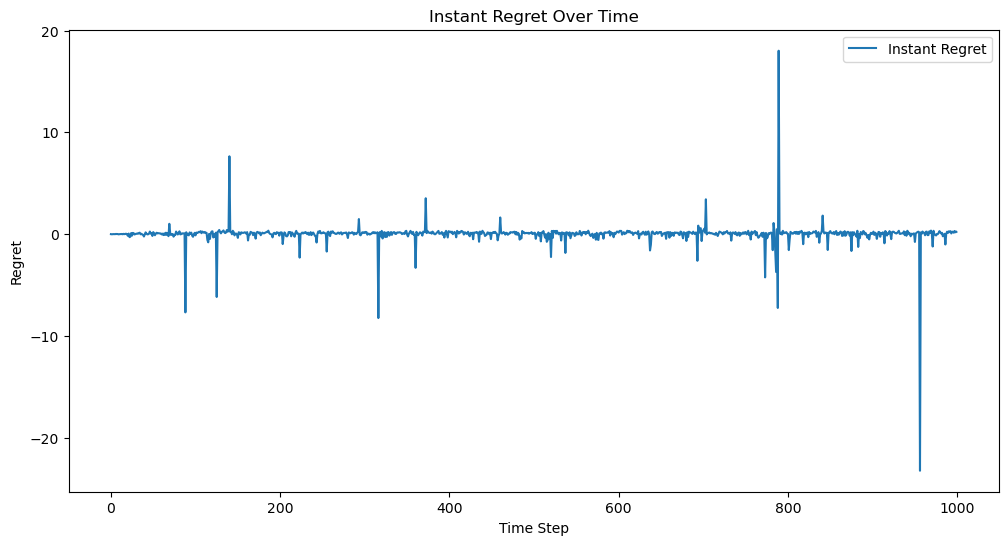

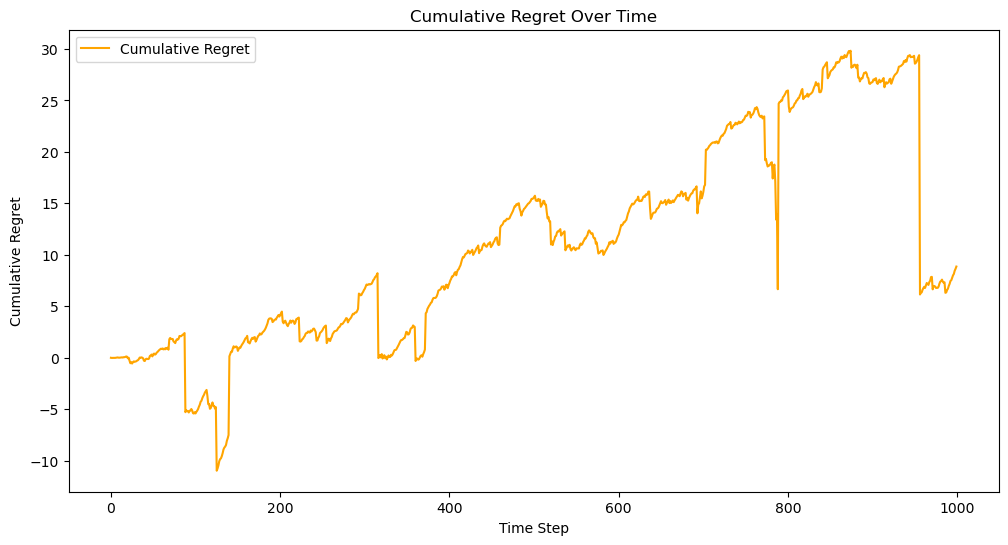

Cumulative Regret: 8.861159299739256


In [136]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
N = 20  # 节点数
T = 1000  # 时间步数
epsilon = 0.1  # epsilon-greedy 算法中的epsilon值

# 初始化每个节点的负载分布参数（均值和标准差）
means = np.random.uniform(0, 10, N)  # 均值在0到10之间的均匀分布
stds = np.random.uniform(1, 2, N)  # 标准差在1到2之间的均匀分布

# 初始化奖励记录
Q = np.zeros(N)  # 累计奖励
N_j = np.zeros(N)  # 选择次数

# 记录选择的节点和对应的奖励
choices = []
rewards = []
instant_regrets = []

# epsilon-greedy 算法
for t in range(T):
    if np.random.rand() < epsilon:
        # 随机选择一个节点
        j = np.random.randint(0, N)
    else:
        # 选择当前累计奖励最大的节点
        j = np.argmax(Q)

    # 生成该节点的负载并计算奖励
    load = np.random.normal(means[j], stds[j])
    reward = 1 / (1 + load)

    # 更新累计奖励和选择次数
    N_j[j] += 1
    Q[j] += (reward - Q[j]) / N_j[j]

    # 记录选择的节点和奖励
    choices.append(j)
    rewards.append(reward)

    # 计算单次遗憾
    mu_star_hat = np.max(Q)
    instant_regret = mu_star_hat - reward
    instant_regrets.append(instant_regret)

# 计算累积遗憾
cumulative_regrets = np.cumsum(instant_regrets)

# 绘制单次遗憾折线图
plt.figure(figsize=(12, 6))
plt.plot(instant_regrets, label='Instant Regret')
plt.xlabel('Time Step')
plt.ylabel('Regret')
plt.title('Instant Regret Over Time')
plt.legend()
plt.show()

# 绘制累积遗憾折线图
plt.figure(figsize=(12, 6))
plt.plot(cumulative_regrets, label='Cumulative Regret', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Over Time')
plt.legend()
plt.show()

# 打印结果
print(f"Cumulative Regret: {cumulative_regrets[-1]}")
